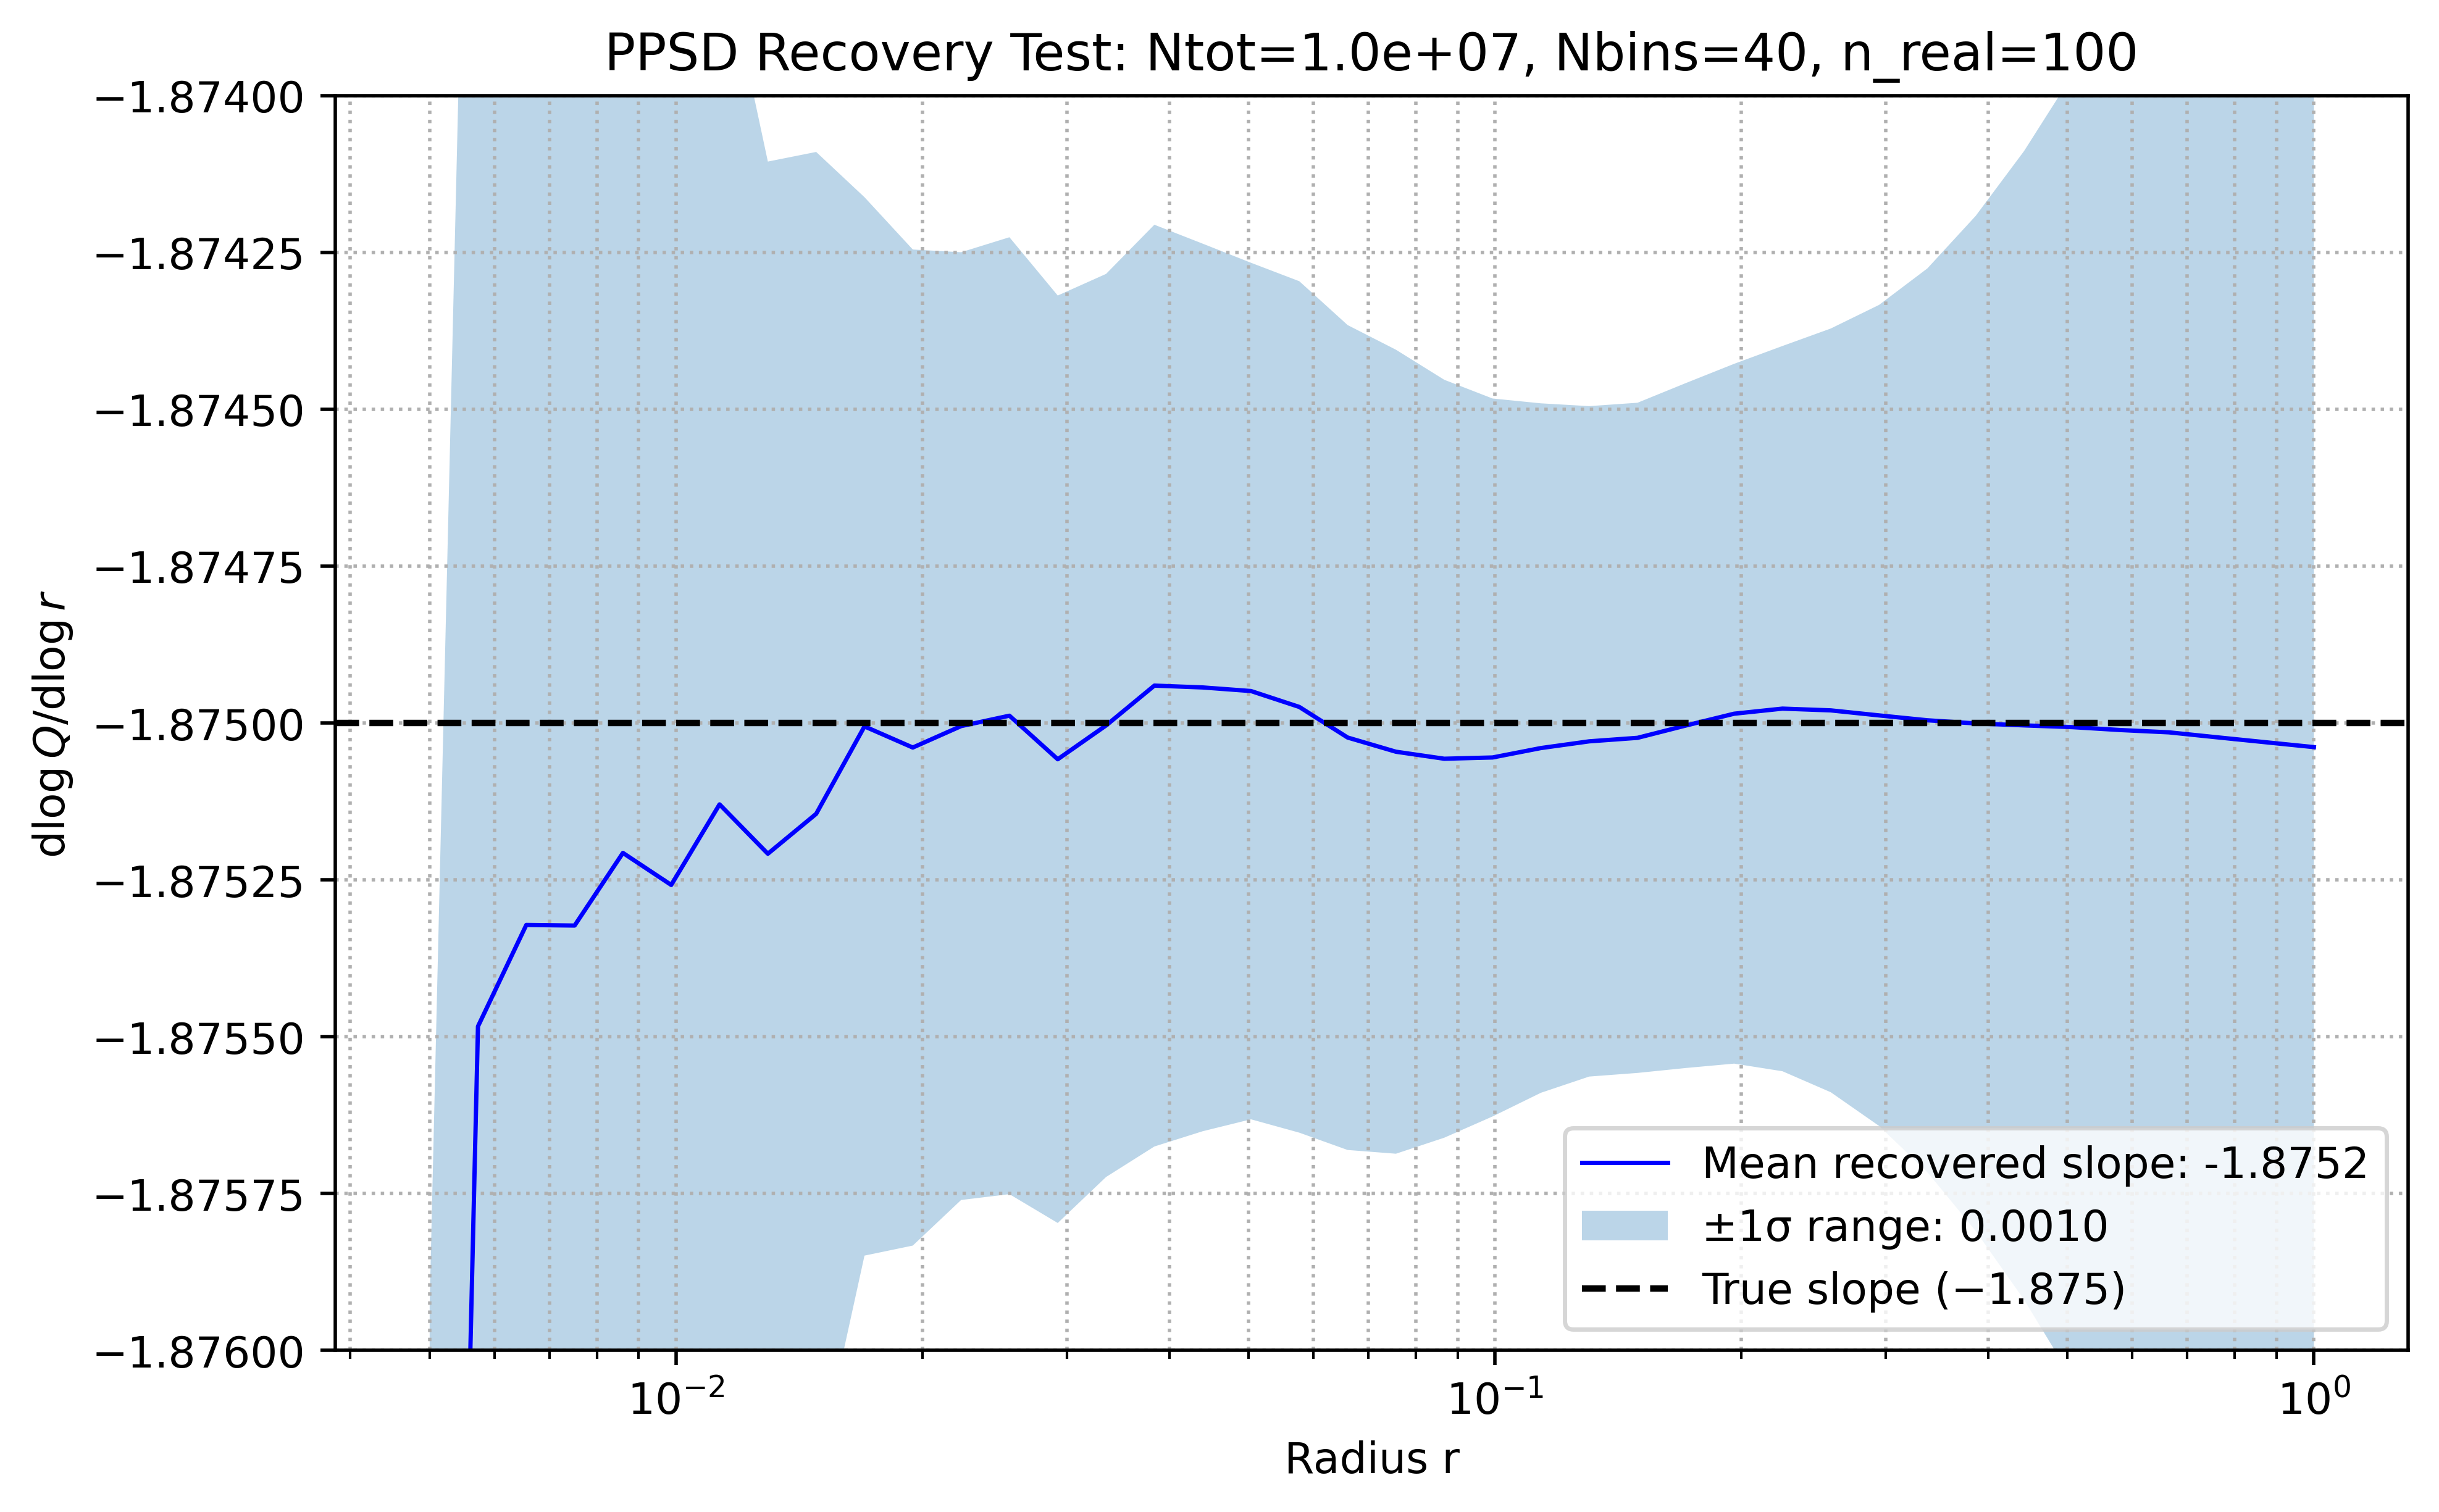

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pynumdiff.optimize import kalman_smooth as ks_opt
from pynumdiff import kalman_smooth as ks

def recovery_test_multiple(Ntot, Nbins, chi, rmin, rmax, n_real=100):
    """
    Perform PPSD recovery test with multiple noisy realizations.
    
    Parameters:
    - Ntot: int
        Total number of particles in the mock halo.
    - Nbins: int
        Number of logarithmic radial bins.
    - chi: float
        True PPSD exponent (e.g. 1.875).
    - rmin, rmax: floats
        Minimum and maximum radius for the profile (e.g. [0.01, 1.0]).
    - n_real: int, optional
        Number of noisy realizations to average over.
        
    Returns:
    - mean_slope: ndarray
        Mean of recovered slopes across all realizations.
    - rms_slope: ndarray
        RMS of recovered slopes across all realizations.
    """
    r = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)
    log_r = np.log10(r)
    
    # Collect slopes for all realizations
    all_slopes = []
    for _ in range(n_real):
        Q_true = r**(-chi)
        Ni = Ntot / Nbins
        sigma_poisson = 1.0 / np.sqrt(Ni)
        noise = np.random.normal(0, sigma_poisson, size=Nbins)
        Q_noisy = Q_true * (1 + noise)
        log_Q_noisy = np.log10(Q_noisy)

        # Recover slope via kalman_smooth.constant_jerk
        dt = np.mean(np.diff(log_r))
        params, _ = ks_opt.constant_jerk(log_Q_noisy, dt)
        _, slope = ks.constant_jerk(log_Q_noisy, dt, params)
        all_slopes.append(slope)

    # Convert to arrays for easy calculation
    all_slopes = np.array(all_slopes)

    # Calculate mean and RMS of the recovered slopes
    mean_slope = np.mean(all_slopes, axis=0)
    rms_slope = np.std(all_slopes, axis=0)

    # Calculate bias
    bias = np.mean(mean_slope) - (-chi)

    mean_slope_value = np.mean(mean_slope)
    rms_slope_value = np.mean(rms_slope)
    plt.figure(figsize=(8, 5), dpi=500)
    plt.plot(r, mean_slope, label=f'Mean recovered slope: {mean_slope_value:.4f}', color='blue', lw=1)
    plt.ylim(-1.876, -1.874)
    plt.fill_between(r, mean_slope - rms_slope, mean_slope + rms_slope, alpha=0.3, label=f'±1σ range: {rms_slope_value:.4f}')
    plt.axhline(-chi, ls='--', color='k', label=f'True slope (−{chi})')
    plt.xscale('log')
    plt.xlabel('Radius r')
    plt.ylabel(r'$\mathrm{d}\log Q / \mathrm{d}\log r$')
    plt.title(f'PPSD Recovery Test: Ntot={Ntot:.1e}, Nbins={Nbins}, n_real={n_real}')
    plt.legend()
    plt.grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.show()

recovery_test_multiple(Ntot=1e7, Nbins=40, chi=1.875, rmin=5e-3, rmax=1, n_real=100)


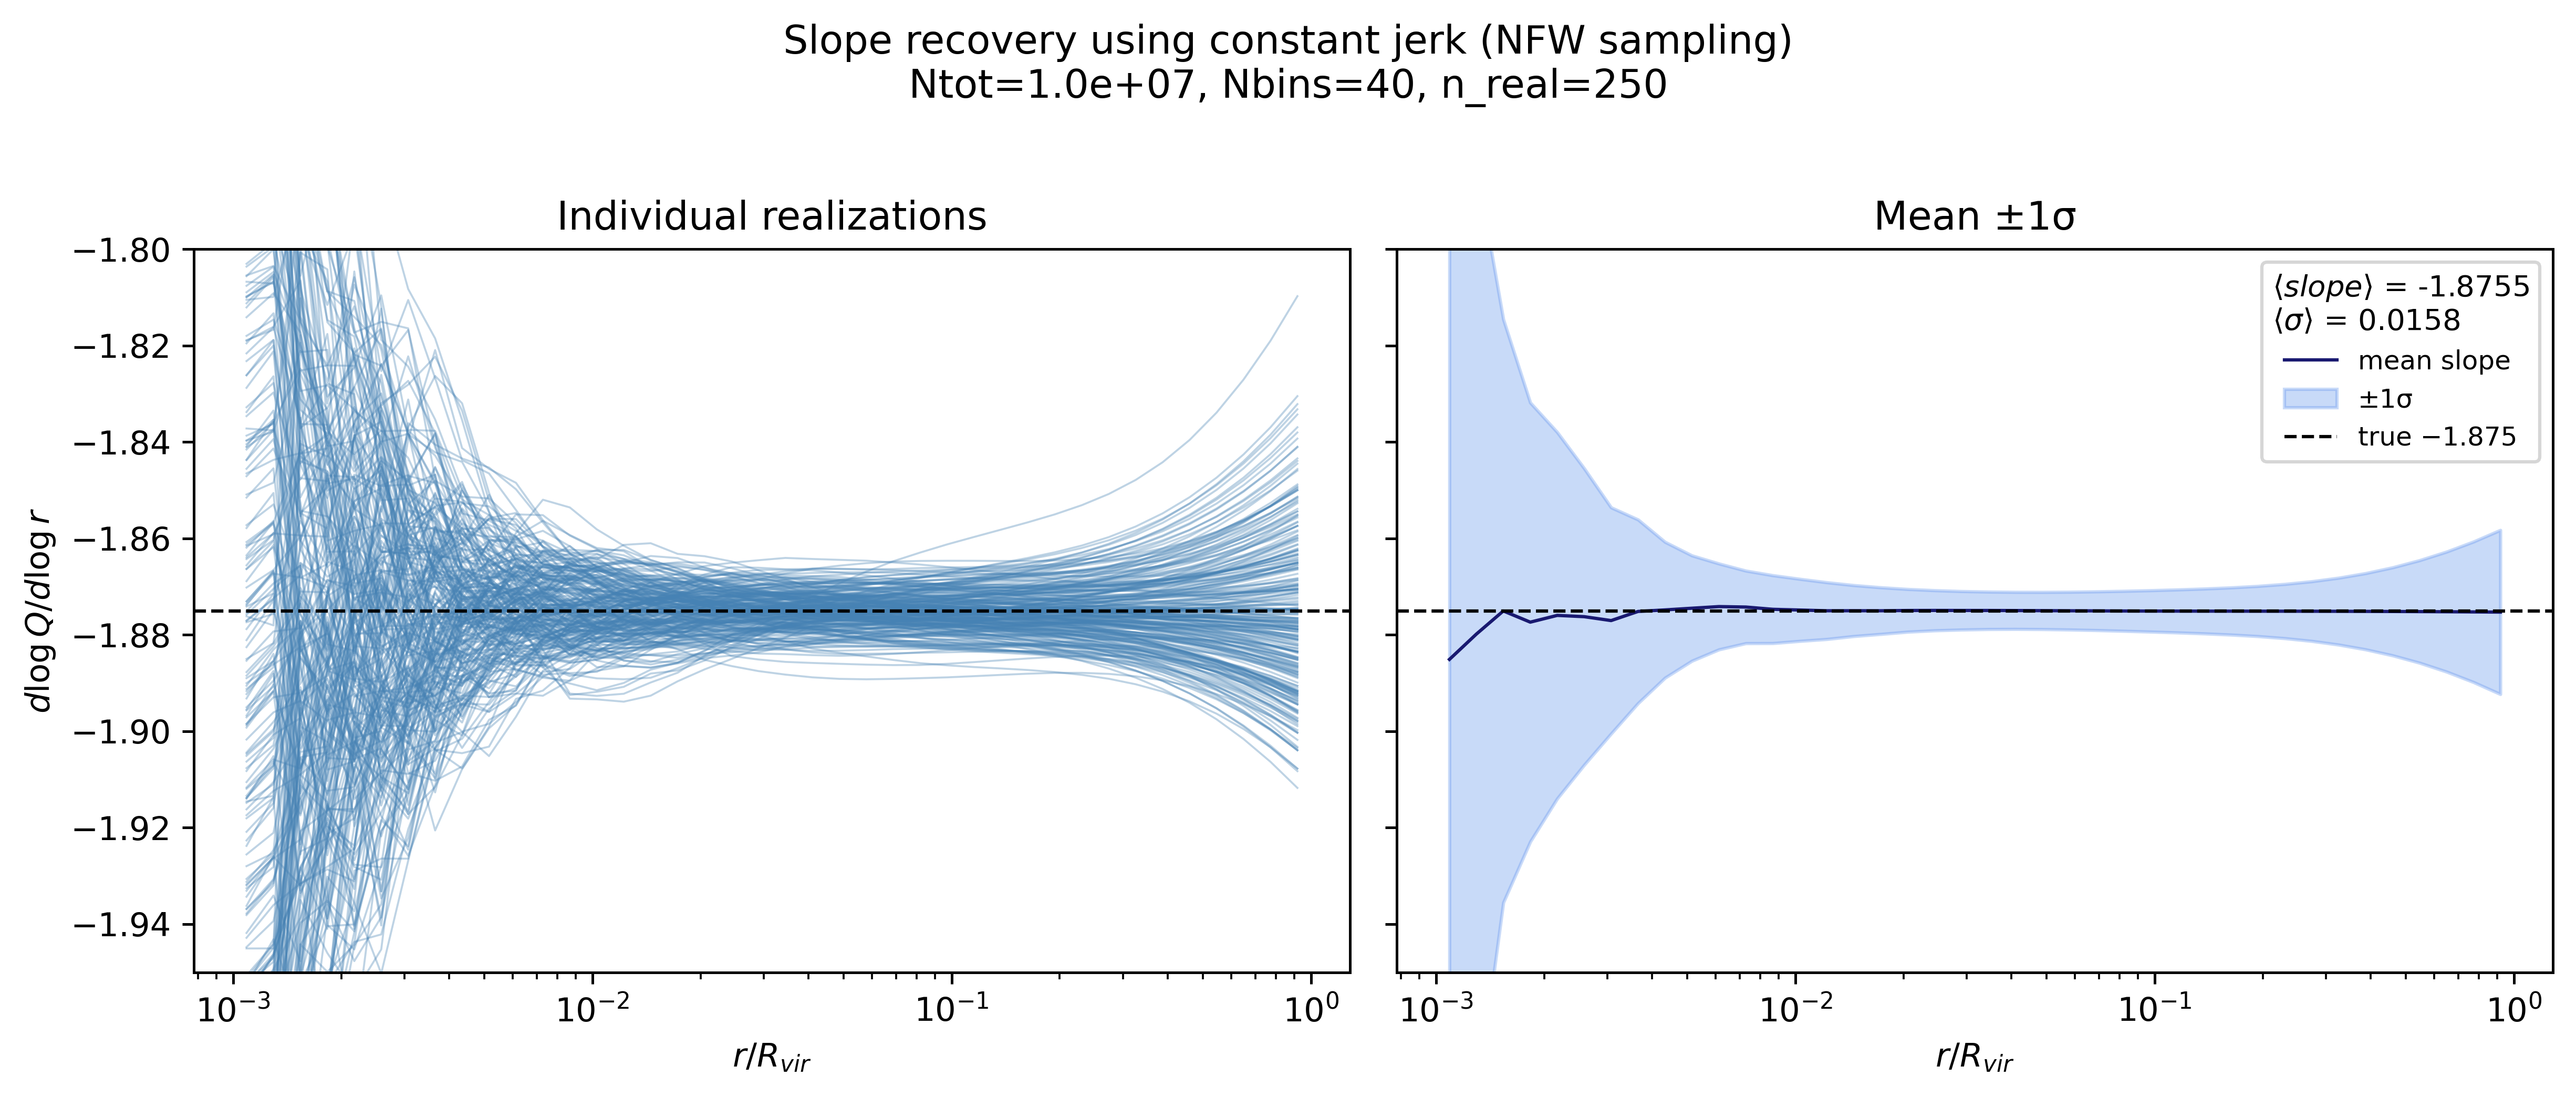

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from pynumdiff.optimize import kalman_smooth as ks_opt
from pynumdiff import kalman_smooth as ks

def nfw_cumulative_mass(x, cvir):
    g = 1.0 / (np.log(1 + cvir) - cvir / (1 + cvir))
    return g * (np.log(1 + cvir*x) - cvir*x/(1 + cvir*x))

def compute_particle_counts(Ntot, rmin, rmax, Nbins, cvir):
    edges = np.logspace(np.log10(rmin), np.log10(rmax), Nbins + 1)
    counts = np.empty(Nbins)
    m_tot  = nfw_cumulative_mass(rmax, cvir)
    for i in range(Nbins):
        m_hi  = nfw_cumulative_mass(edges[i+1], cvir)
        m_lo  = nfw_cumulative_mass(edges[i],   cvir)
        counts[i] = Ntot * (m_hi - m_lo) / m_tot
    return counts, edges

def noisy_Q_profile_with_nfw(chi, edges, Ntot, cvir):
    r_mid = np.sqrt(edges[:-1] * edges[1:])
    Q_true = r_mid**(-chi)
    N_i, _  = compute_particle_counts(Ntot, edges[0], edges[-1],
                                      len(edges)-1, cvir)
    counts  = np.random.poisson(lam=N_i)
    return r_mid, Q_true * (counts / N_i)

def plot_recovery_test(chi=1.875, Ntot=1e7, Nbins=40,
                   n_real=250, rmin=1e-3, rmax=1.0, cvir=10):

    edges  = np.logspace(np.log10(rmin), np.log10(rmax), Nbins+1)
    r_mid  = np.sqrt(edges[:-1] * edges[1:])
    dt     = np.mean(np.diff(np.log10(r_mid)))

    slopes_stack = np.empty((n_real, Nbins))

    # ---------- figure & axes ----------
    fig, (ax_indiv, ax_mean) = plt.subplots(1, 2, figsize=(11,4.5),
                                            dpi=450, sharey=True)

    for k in range(n_real):
        _, Qn = noisy_Q_profile_with_nfw(chi, edges, Ntot, cvir)
        params, _   = ks_opt.constant_jerk(np.log10(Qn), dt)
        _, slope_k  = ks.constant_jerk(np.log10(Qn), dt, params)

        slopes_stack[k] = slope_k
        ax_indiv.plot(r_mid, slope_k, color='steelblue', alpha=0.35, lw=0.6)

    # ---- mean & sigma over realisations ----
    slope_mean = slopes_stack.mean(axis=0)
    slope_std  = slopes_stack.std(axis=0, ddof=1)

    mean_of_mean   = slope_mean.mean()
    mean_of_sigma  = slope_std.mean()

    # ---------- right panel ----------
    ax_mean.plot(r_mid, slope_mean, color='midnightblue', lw=1,
                 label='mean slope')
    ax_mean.fill_between(r_mid, slope_mean-slope_std, slope_mean+slope_std,
                         color='cornflowerblue', alpha=0.35, label='±1σ')
    ax_mean.axhline(-chi, ls='--', color='k', lw=1,
                    label=f"true −{chi}")

    # legend with global stats
    ax_mean.legend(title=(rf"$\langle slope \rangle$ = {mean_of_mean:.4f}"
                          "\n"
                          rf"$\langle\sigma\rangle$ = {mean_of_sigma:.4f}"),
                   fontsize=8, title_fontsize=9)

    for ax in (ax_indiv, ax_mean):
        ax.set_xscale('log')
        ax.set_xlabel(r'$r / R_{vir}$')
        ax.set_ylim(-1.95, -1.8)
    ax_indiv.axhline(-chi, ls='--', color='k', lw=1,
                     label=f"true −{chi}")
    ax_indiv.set_title('Individual realizations')
    ax_mean .set_title('Mean ±1σ')
    ax_indiv.set_ylabel(r'$d\log Q / d\log r$')

    fig.suptitle(f'Slope recovery using constant jerk (NFW sampling)'
                 f'\nNtot={Ntot:.1e}, Nbins={Nbins}, n_real={n_real}',
                 y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

plot_recovery_test()

Radial range with <10% slope deviation: (np.float64(0.001090184492385128), np.float64(0.9172759353897795))


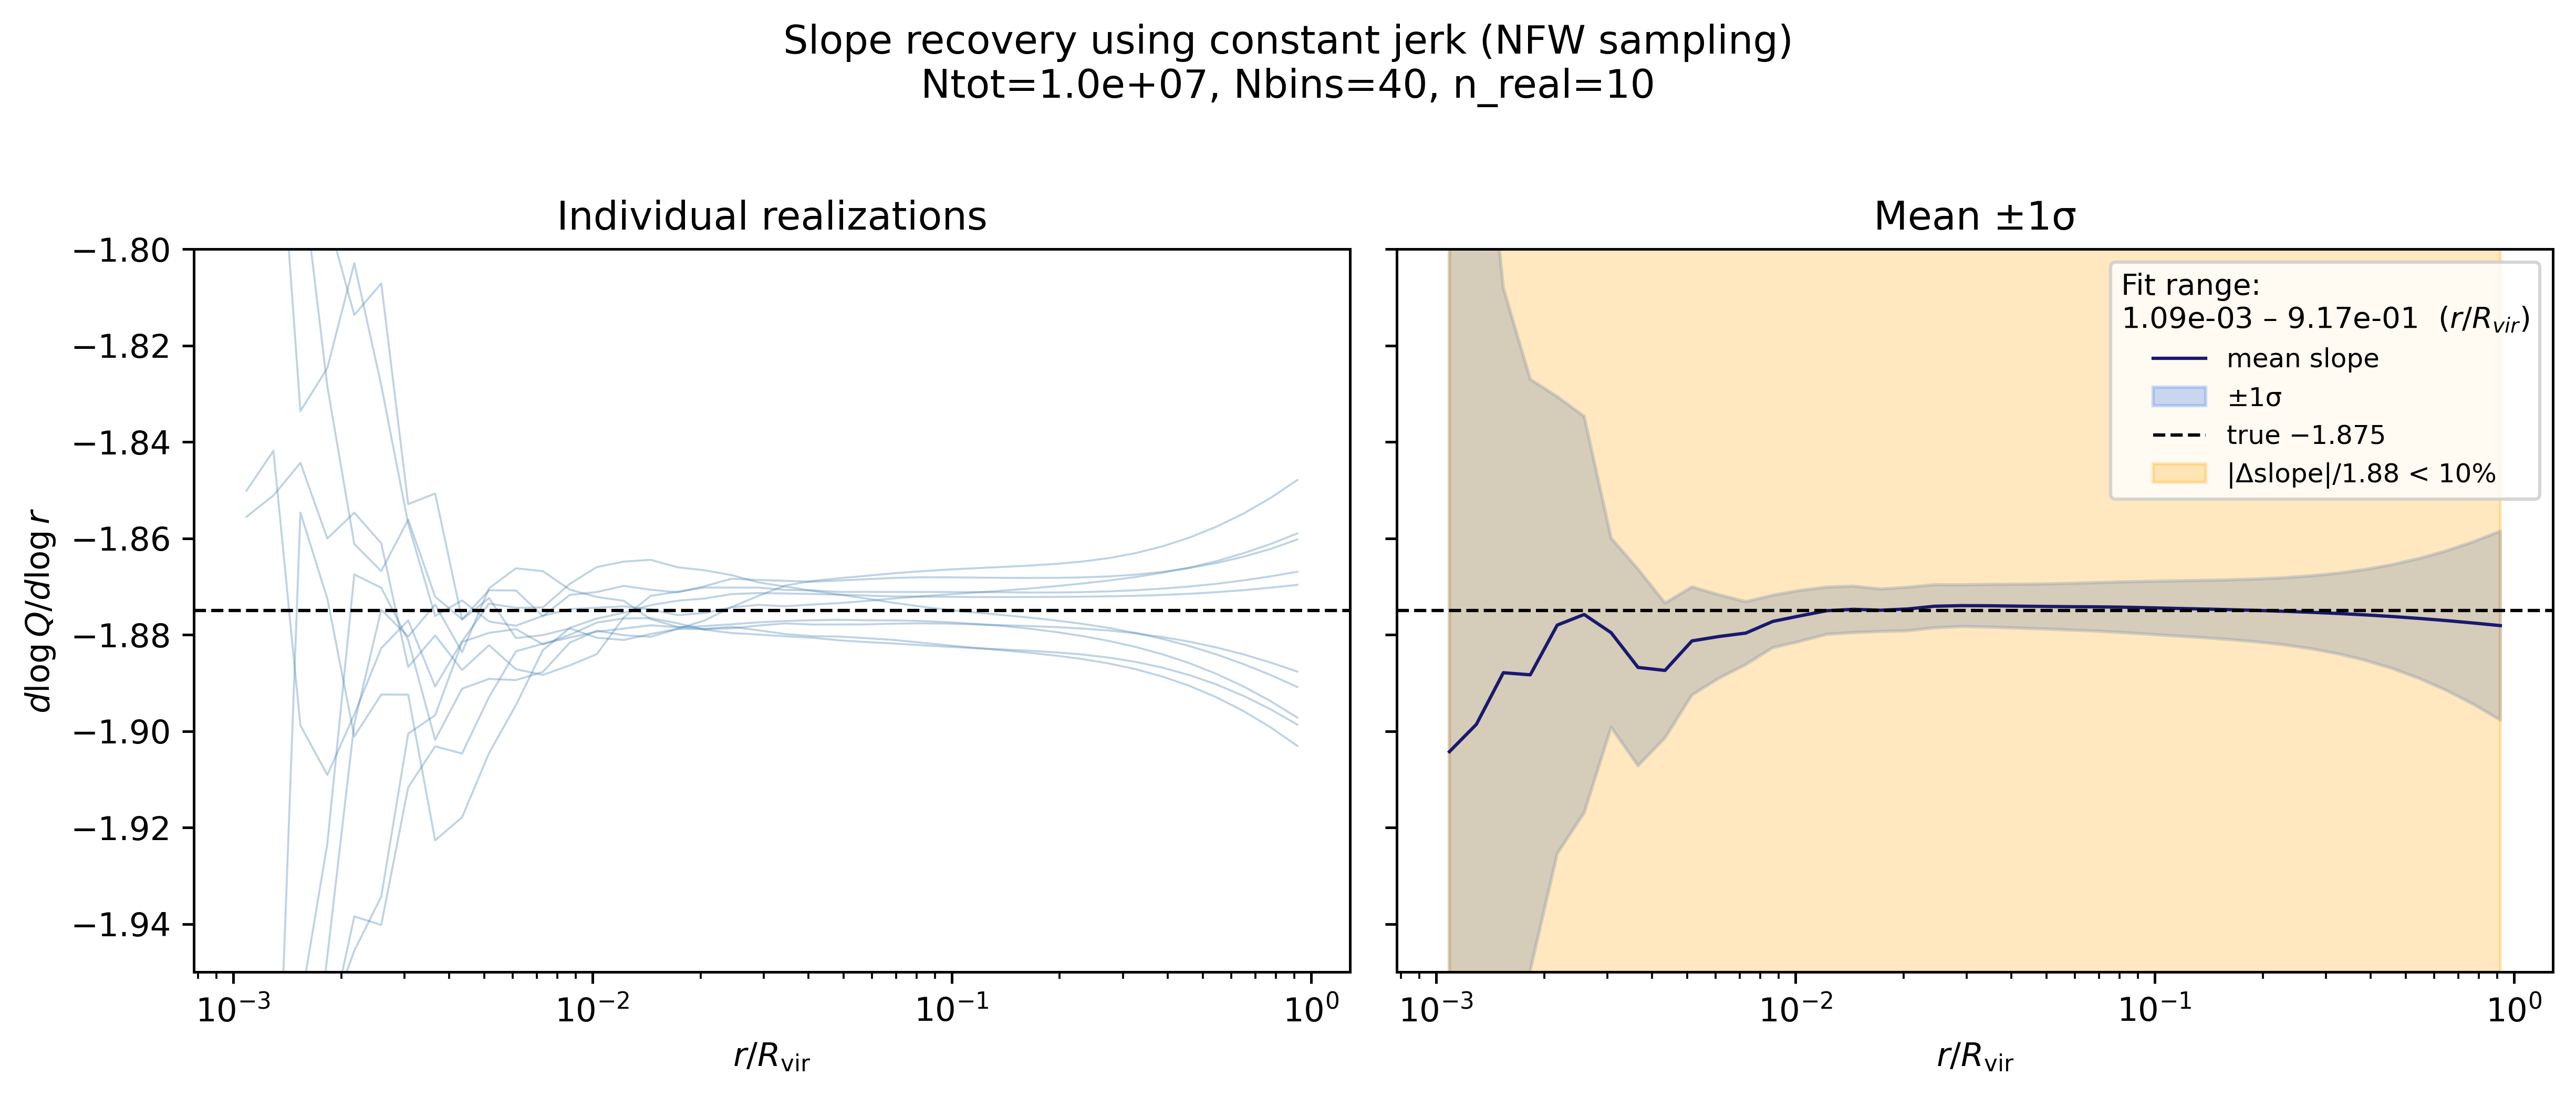

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pynumdiff.optimize import kalman_smooth as ks_opt
from pynumdiff import kalman_smooth as ks


def nfw_cumulative_mass(x, cvir):
    g = 1.0 / (np.log(1 + cvir) - cvir / (1 + cvir))
    return g * (np.log(1 + cvir * x) - cvir * x / (1 + cvir * x))


def compute_particle_counts(Ntot, rmin, rmax, Nbins, cvir):
    edges = np.logspace(np.log10(rmin), np.log10(rmax), Nbins + 1)
    counts = np.empty(Nbins)
    m_tot = nfw_cumulative_mass(rmax, cvir)
    for i in range(Nbins):
        m_hi = nfw_cumulative_mass(edges[i + 1], cvir)
        m_lo = nfw_cumulative_mass(edges[i], cvir)
        counts[i] = Ntot * (m_hi - m_lo) / m_tot
    return counts, edges


def noisy_Q_profile_with_nfw(chi, edges, Ntot, cvir, rng=np.random):
    r_mid = np.sqrt(edges[:-1] * edges[1:])
    Q_true = r_mid ** (-chi)
    N_i, _ = compute_particle_counts(Ntot, edges[0], edges[-1],
                                     len(edges) - 1, cvir)
    counts = rng.poisson(lam=N_i)
    return r_mid, Q_true * (counts / N_i)


def determine_radial_fit_range(r_mid, slope_mean, chi,
                               tol=0.10, min_bins=2):
    deviation = np.abs(slope_mean + chi) / chi
    ok = deviation < tol
    if not np.any(ok):
        return None, None

    best_start, best_end, best_len = None, None, 0
    run_start = None

    for i, flag in enumerate(ok):
        if flag and run_start is None:
            run_start = i
        elif not flag and run_start is not None:
            run_end = i - 1
            run_len = run_end - run_start + 1
            if run_len > best_len:
                best_start, best_end, best_len = run_start, run_end, run_len
            run_start = None

    if run_start is not None:                                  # trailing run
        run_end = len(ok) - 1
        run_len = run_end - run_start + 1
        if run_len > best_len:
            best_start, best_end = run_start, run_end

    if best_end - best_start + 1 < min_bins:
        return None, None

    return r_mid[best_start], r_mid[best_end]


def plot_recovery_test(chi=1.875, Ntot=1e7, Nbins=40, n_real=250,
                       rmin=1e-3, rmax=1.0, cvir=10, frac_tol=0.10,
                       seed=None):
    rng = np.random.default_rng(seed)

    edges = np.logspace(np.log10(rmin), np.log10(rmax), Nbins + 1)
    r_mid = np.sqrt(edges[:-1] * edges[1:])
    dt = np.mean(np.diff(np.log10(r_mid)))

    slopes_stack = np.empty((n_real, Nbins))

    fig, (ax_indiv, ax_mean) = plt.subplots(1, 2, figsize=(11, 4.5),
                                            dpi=450, sharey=True)

    for k in range(n_real):
        _, Qn = noisy_Q_profile_with_nfw(chi, edges, Ntot, cvir, rng=rng)
        params, _ = ks_opt.constant_jerk(np.log10(Qn), dt)
        _, slope_k = ks.constant_jerk(np.log10(Qn), dt, params)

        slopes_stack[k] = slope_k
        ax_indiv.plot(r_mid, slope_k, color='steelblue', alpha=0.35, lw=0.6)

    slope_mean = slopes_stack.mean(axis=0)
    slope_std = slopes_stack.std(axis=0, ddof=1)

    ax_mean.plot(r_mid, slope_mean, color='midnightblue', lw=1,
                 label='mean slope')
    ax_mean.fill_between(r_mid, slope_mean - slope_std,
                         slope_mean + slope_std,
                         color='cornflowerblue', alpha=0.35, label='±1σ')
    ax_mean.axhline(-chi, ls='--', color='k', lw=1,
                    label=f"true −{chi}")

    rmin_fit, rmax_fit = determine_radial_fit_range(r_mid, slope_mean,
                                                    chi, tol=frac_tol)
    if rmin_fit is not None:
        ax_mean.axvspan(rmin_fit, rmax_fit, color='orange', alpha=0.25,
                        label=f'|Δslope|/{chi:.3g} < {frac_tol:.0%}')
        txt = (f"Fit range:\n"
               f"{rmin_fit:.2e} – {rmax_fit:.2e}  ($r/R_{{vir}}$)")
    else:
        txt = "No contiguous range\nmeets criterion"

    ax_mean.legend(title=txt, fontsize=8, title_fontsize=9)

    for ax in (ax_indiv, ax_mean):
        ax.set_xscale('log')
        ax.set_xlabel(r'$r / R_{\mathrm{vir}}$')
        ax.set_ylim(-1.95, -1.8)
    ax_indiv.axhline(-chi, ls='--', color='k', lw=1)
    ax_indiv.set_title('Individual realizations')
    ax_mean.set_title('Mean ±1σ')
    ax_indiv.set_ylabel(r'$d\log Q / d\log r$')

    fig.suptitle(f'Slope recovery using constant jerk (NFW sampling)'
                 f'\nNtot={Ntot:.1e}, Nbins={Nbins}, n_real={n_real}',
                 y=1.02, fontsize=12)
    fig.tight_layout()
    return rmin_fit, rmax_fit


# Example usage
if __name__ == "__main__":
    rmin_ok, rmax_ok = plot_recovery_test(
        chi=1.875,
        Ntot=1e7,
        Nbins=40,
        n_real=10,
        rmin=1e-3,
        rmax=1.0,
        cvir=8.3,
        frac_tol=0.10,
    )
    print("Radial range with <10% slope deviation:",
          (rmin_ok, rmax_ok))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pynumdiff.optimize import kalman_smooth as ks_opt
from pynumdiff            import kalman_smooth as ks


def nfw_cumulative_mass(x, c):
    g = 1.0 / (np.log(1 + c) - c / (1 + c))
    return g * (np.log(1 + c*x) - c*x/(1 + c*x))

def particle_counts(Ntot, edges, cvir):
    m_tot = nfw_cumulative_mass(edges[-1], cvir)
    cnt   = [(nfw_cumulative_mass(edges[i+1], cvir) -
              nfw_cumulative_mass(edges[i],   cvir)) / m_tot * Ntot
             for i in range(len(edges)-1)]
    return np.asarray(cnt)

def noisy_slopes(chi, edges, Ntot, cvir, dt):
    r_mid  = np.sqrt(edges[:-1] * edges[1:])
    Q_true = r_mid**(-chi)
    Q_noisy= Q_true * np.random.poisson(particle_counts(Ntot, edges, cvir)) \
                      / particle_counts(Ntot, edges, cvir)
    p,_    = ks_opt.constant_jerk(np.log10(Q_noisy), dt)
    _,s    = ks.constant_jerk(np.log10(Q_noisy), dt, p)
    return s

def plot_bias_vs_sigma(chi=1.875,
                       N_tot=np.logspace(5,9,9),  
                       Nbins=40, n_real=50,
                       rmin=1e-3, rmax=1.0, cvir=10):

    # radial bins
    edges = np.logspace(np.log10(rmin), np.log10(rmax), Nbins+1)
    dt    = np.mean(np.diff(np.log10(np.sqrt(edges[:-1]*edges[1:]))))

    bias, sigma = [], []

    for N in N_tot:
        slopes = np.array([noisy_slopes(chi, edges, N, cvir, dt)
                           for _ in range(n_real)])

        mean_each   = slopes.mean(axis=1)            # mean slope per run
        sigma_each  = slopes.std (axis=1, ddof=1)    # scatter per run

        bias .append(mean_each.mean() + chi)
        sigma.append(sigma_each.mean())

    bias  = np.asarray(bias)
    sigma = np.asarray(sigma)

    # ----------------- plot -----------------
    fig, ax1 = plt.subplots(figsize=(7.2,4.2), dpi=500)

    bias = ax1.errorbar(N_tot, bias, yerr=sigma,             
                 fmt='o-',  color='darkorange',
                 ecolor='peachpuff', capsize=3,
                 label='bias (error bar = ⟨σ⟩)', markersize=4)
    ax1.set_xscale('log')
    ax1.set_ylabel('bias', color='darkorange')
    ax1.tick_params(axis='y', colors='darkorange')

    ax2 = ax1.twinx()
    sigma = ax2.plot(N_tot, sigma, 's--', color='steelblue', label=r'$\langle\sigma\rangle$', markersize=4)
    ax2.set_yscale('log')
    ax2.set_ylabel(r'$\langle\sigma\rangle$', color='steelblue')
    ax2.tick_params(axis='y', colors='steelblue')

    ax1.legend([bias.lines[0], sigma.lines[0]],
            [bias.lines[0].get_label(),
                sigma.lines[0].get_label()],
            loc='upper right', fontsize=8)
    
    ax1.set_xlabel(r'Total particle number $N_{\rm tot}$')
    ax1.set_title(r'Bias and scatter vs $N_{\rm tot}$ '
                  rf'(Nbins={Nbins}, n_real={n_real})')
    ax1.grid(alpha=0.25)
    fig.tight_layout()
    plt.show()

plot_bias_vs_sigma()